# Quantium - Module 2

We will be examining the performance in trial vs control stores to provide a recommendation for each location based on our insight.

- Select control stores – explore the data and define metrics for control store selection – "What would make them a control store?" Visualize the drivers to see suitability.

- Assessment of the trial – get insights of each of the stores. Compare each trial store with ontrol store to get its overall performance. We want to know if the trial stores were successful or not. 

- Collate findings – summarise findings for each store and provide recommendations to share with client outlining the impact on sales during trial period.

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [60]:
qvi = pd.read_csv("QVI_data.csv")
qvi.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [61]:
# Checking for nulls
qvi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
LYLTY_CARD_NBR      264834 non-null int64
DATE                264834 non-null object
STORE_NBR           264834 non-null int64
TXN_ID              264834 non-null int64
PROD_NBR            264834 non-null int64
PROD_NAME           264834 non-null object
PROD_QTY            264834 non-null int64
TOT_SALES           264834 non-null float64
PACK_SIZE           264834 non-null int64
BRAND               264834 non-null object
LIFESTAGE           264834 non-null object
PREMIUM_CUSTOMER    264834 non-null object
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


- Client has selected store numbers 77, 86 and 88 as trial stores.
- Client wants control stores to be established stores that are operational for the entire observation period.
- Trial period = 1 Feb 2019 to 30 April 2019.
- Compare trial stores to control stores that are similar pre-trial. Similarity measurement:
    - Monthly overall sales revenue
    - Monthly number of customers
    - Monthly number of transactions per customer


In [62]:
qvi["DATE"] = pd.to_datetime(qvi["DATE"])
qvi["YEARMONTH"] = qvi["DATE"].dt.strftime("%Y%m").astype("int")

Compile each store's monthly:
- Total sales
- Number of customers,
- Average transactions per customer
- Average chips per customer
- Average price per unit

In [63]:
def monthly_store_metrics():
    store_yrmo_group = qvi.groupby(["STORE_NBR", "YEARMONTH"])
    total = store_yrmo_group["TOT_SALES"].sum()
    num_cust = store_yrmo_group["LYLTY_CARD_NBR"].nunique()
    trans_per_cust = store_yrmo_group.size() / num_cust
    avg_chips_per_cust = store_yrmo_group["PROD_QTY"].sum() / num_cust
    avg_chips_price = total / store_yrmo_group["PROD_QTY"].sum()
    aggregates = [total, num_cust, trans_per_cust, avg_chips_per_cust, avg_chips_price]
    metrics = pd.concat(aggregates, axis=1)
    metrics.columns = ["TOT_SALES", "nCustomers", "nTxnPerCust", "nChipsPerTxn", "avgPricePerUnit"]
    return metrics

In [64]:
qvi_monthly_metrics = monthly_store_metrics().reset_index()
qvi_monthly_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3169 entries, 0 to 3168
Data columns (total 7 columns):
STORE_NBR          3169 non-null int64
YEARMONTH          3169 non-null int64
TOT_SALES          3169 non-null float64
nCustomers         3169 non-null int64
nTxnPerCust        3169 non-null float64
nChipsPerTxn       3169 non-null float64
avgPricePerUnit    3169 non-null float64
dtypes: float64(4), int64(3)
memory usage: 173.4 KB


In [65]:
#pre trial observation
#filter only stores with full 12 months observation
observ_counts = qvi_monthly_metrics["STORE_NBR"].value_counts()
full_observ_index = observ_counts[observ_counts == 12].index
full_observ = qvi_monthly_metrics[qvi_monthly_metrics["STORE_NBR"].isin(full_observ_index)]
pretrial_full_observ = full_observ[full_observ["YEARMONTH"] < 201902]

pretrial_full_observ.head(8)

,STORE_NBR,YEARMONTH,TOT_SALES,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,1.061224,1.265306,3.337097
1,1,201808,176.1,42,1.023810,1.285714,3.261111
2,1,201809,278.8,59,1.050847,1.271186,3.717333
3,1,201810,188.1,44,1.022727,1.318182,3.243103
4,1,201811,192.6,46,1.021739,1.239130,3.378947
5,1,201812,189.6,42,1.119048,1.357143,3.326316
6,1,201901,154.8,35,1.028571,1.200000,3.685714
12,2,201807,150.8,39,1.051282,1.179487,3.278261


In [66]:
def calcCorrTable(metricCol, storeComparison, inputTable=pretrial_full_observ):
    """Calculate correlation for a measure, looping through each control store.
    Args:
        metricCol (str): Name of column containing store's metric to perform correlation test on.
        storeComparison (int): Trial store's number.
        inputTable (dataframe):  Metric table with potential comparison stores.
        
    Returns:
        DataFrame: Monthly correlation table between Trial and each Control stores.
    """
    control_store_nbrs = inputTable[~inputTable["STORE_NBR"].isin([77, 86, 88])]["STORE_NBR"].unique()
    corrs = pd.DataFrame(columns = ["YEARMONTH", "Trial_Str", "Ctrl_Str", "Corr_Score"])
    trial_store = inputTable[inputTable["STORE_NBR"] == storeComparison][metricCol].reset_index()
    for control in control_store_nbrs:
        concat_df = pd.DataFrame(columns = ["YEARMONTH", "Trial_Str", "Ctrl_Str", "Corr_Score"])
        control_store = inputTable[inputTable["STORE_NBR"] == control][metricCol].reset_index()
        concat_df["Corr_Score"] = trial_store.corrwith(control_store, axis=1)
        concat_df["Trial_Str"] = storeComparison
        concat_df["Ctrl_Str"] = control
        concat_df["YEARMONTH"] = list(inputTable[inputTable["STORE_NBR"] == storeComparison]["YEARMONTH"])
        corrs = pd.concat([corrs, concat_df])
    return corrs

In [67]:
corr_table = pd.DataFrame()
for trial_num in [77, 86, 88]:
    corr_table = pd.concat([corr_table, calcCorrTable(["TOT_SALES", "nCustomers", "nTxnPerCust", "nChipsPerTxn", "avgPricePerUnit"], trial_num)])
    
corr_table.head(8)

,YEARMONTH,Trial_Str,Ctrl_Str,Corr_Score
0,201807,77,1,0.070414
1,201808,77,1,0.027276
2,201809,77,1,0.002389
3,201810,77,1,-0.020045
4,201811,77,1,0.030024
5,201812,77,1,0.063946
6,201901,77,1,0.001470
0,201807,77,2,0.142957


In [68]:
def calculateMagnitudeDistance(metricCol, storeComparison, inputTable=pretrial_full_observ):
    """Calculate standardised magnitude distance for a measure, looping through each control store.
    Args:
        metricCol (str): Name of column containing store's metric to perform distance calculation on.
        storeComparison (int): Trial store's number.
        inputTable (dataframe):  Metric table with potential comparison stores.
        
    Returns:
        DataFrame: Monthly magnitude-distance table between Trial and each Control stores.
    """
    control_store_nbrs = inputTable[~inputTable["STORE_NBR"].isin([77, 86, 88])]["STORE_NBR"].unique()
    dists = pd.DataFrame()
    trial_store = inputTable[inputTable["STORE_NBR"] == storeComparison][metricCol]
    for control in control_store_nbrs:
        concat_df  = abs(inputTable[inputTable["STORE_NBR"] == storeComparison].reset_index()[metricCol] - inputTable[inputTable["STORE_NBR"] == control].reset_index()[metricCol])
        concat_df["YEARMONTH"] = list(inputTable[inputTable["STORE_NBR"] == storeComparison]["YEARMONTH"])
        concat_df["Trial_Str"] = storeComparison
        concat_df["Ctrl_Str"] = control
        dists = pd.concat([dists, concat_df])
    for col in metricCol:
        dists[col] = 1 - ((dists[col] - dists[col].min()) / (dists[col].max() - dists[col].min()))
    dists["magnitude"] = dists[metricCol].mean(axis=1)
    return dists    

In [123]:
dist_table = pd.DataFrame()
for trial_num in [77, 86, 88]:
    dist_table = pd.concat([dist_table, calculateMagnitudeDistance(["TOT_SALES", "nCustomers", "nTxnPerCust", "nChipsPerTxn", "avgPricePerUnit"], trial_num)])
    
dist_table.head(8)
dist_table

,TOT_SALES,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,YEARMONTH,Trial_Str,Ctrl_Str,magnitude
0,0.935431,0.980769,0.958035,0.739412,0.883569,201807,77,1,0.899443
1,0.942972,0.951923,0.993823,0.802894,0.886328,201808,77,1,0.915588
2,0.961503,0.836538,0.992126,0.730041,0.703027,201809,77,1,0.844647
3,0.988221,0.932692,0.989514,0.940460,0.590528,201810,77,1,0.888283
4,0.962149,0.951923,0.874566,0.730358,0.832481,201811,77,1,0.870296
5,0.944193,0.961538,0.868716,0.857966,0.770744,201812,77,1,0.880632
6,0.964375,1.000000,0.790956,0.551428,0.678728,201901,77,1,0.797098
0,0.895138,0.884615,0.933787,0.680831,0.848622,201807,77,2,0.848599
1,0.955685,0.923077,0.801752,0.887907,0.957997,201808,77,2,0.905284
2,0.949149,0.942308,0.951610,0.639734,0.674207,201809,77,2,0.831401


We'll select control stores based on how similar monthly total sales in dollar amounts and monthly number of customers are to the trial stores by using correlation and magnitude distance.

In [70]:
def combine_corr_dist(metricCol, storeComparison, inputTable=pretrial_full_observ):
    corrs = calcCorrTable(metricCol, storeComparison, inputTable)
    dists = calculateMagnitudeDistance(metricCol, storeComparison, inputTable)
    dists = dists.drop(metricCol, axis=1)
    combine = pd.merge(corrs, dists, on=["YEARMONTH", "Trial_Str", "Ctrl_Str"])
    return combine

In [71]:
compare_metrics_table1 = pd.DataFrame()
for trial_num in [77, 86, 88]:
    compare_metrics_table1 = pd.concat([compare_metrics_table1, combine_corr_dist(["TOT_SALES"], trial_num)])

In [72]:
corr_weight = 0.5
dist_weight = 1 - corr_weight

In [73]:
#Top 5 highest Composite Score for each Trial Store based on TOT_SALES
grouped_comparison_table1 = compare_metrics_table1.groupby(["Trial_Str", "Ctrl_Str"]).mean().reset_index()
grouped_comparison_table1["CompScore"] = (corr_weight * grouped_comparison_table1["Corr_Score"]) + (dist_weight * grouped_comparison_table1["magnitude"])
for trial_num in compare_metrics_table1["Trial_Str"].unique():
    print(grouped_comparison_table1[grouped_comparison_table1["Trial_Str"] == trial_num].sort_values(ascending=False, by="CompScore").head(), '\n')

     Trial_Str  Ctrl_Str  Corr_Score  magnitude  CompScore
218         77       233         1.0   0.986477   0.993238
239         77       255         1.0   0.979479   0.989739
177         77       188         1.0   0.977663   0.988831
49          77        53         1.0   0.976678   0.988339
120         77       131         1.0   0.976267   0.988134 

     Trial_Str  Ctrl_Str  Corr_Score  magnitude  CompScore
356         86       109         1.0   0.966783   0.983391
401         86       155         1.0   0.965876   0.982938
464         86       222         1.0   0.962280   0.981140
467         86       225         1.0   0.960512   0.980256
471         86       229         1.0   0.951704   0.975852 

     Trial_Str  Ctrl_Str  Corr_Score  magnitude  CompScore
551         88        40         1.0   0.941165   0.970582
538         88        26         1.0   0.904377   0.952189
582         88        72         1.0   0.903800   0.951900
517         88         4         1.0   0.903466   0.

In [74]:
compare_metrics_table2 = pd.DataFrame()
for trial_num in [77, 86, 88]:
    compare_metrics_table2 = pd.concat([compare_metrics_table2, combine_corr_dist(["nCustomers"], trial_num)])

In [75]:
#Top 5 highest Composite Score for each Trial Store based on nCustomers
grouped_comparison_table2 = compare_metrics_table2.groupby(["Trial_Str", "Ctrl_Str"]).mean().reset_index()
grouped_comparison_table2["CompScore"] = (corr_weight * grouped_comparison_table2["Corr_Score"]) + (dist_weight * grouped_comparison_table2["magnitude"])
for trial_num in compare_metrics_table2["Trial_Str"].unique():
    print(grouped_comparison_table2[grouped_comparison_table2["Trial_Str"] == trial_num].sort_values(ascending=False, by="CompScore").head(), '\n')

     Trial_Str  Ctrl_Str  Corr_Score  magnitude  CompScore
218         77       233         1.0   0.993132   0.996566
38          77        41         1.0   0.976648   0.988324
101         77       111         1.0   0.968407   0.984203
105         77       115         1.0   0.967033   0.983516
15          77        17         1.0   0.965659   0.982830 

     Trial_Str  Ctrl_Str  Corr_Score  magnitude  CompScore
401         86       155         1.0   0.986772   0.993386
467         86       225         1.0   0.969577   0.984788
356         86       109         1.0   0.969577   0.984788
471         86       229         1.0   0.964286   0.982143
293         86        39         1.0   0.961640   0.980820 

     Trial_Str  Ctrl_Str  Corr_Score  magnitude  CompScore
736         88       237         1.0   0.987818   0.993909
705         88       203         1.0   0.944629   0.972315
551         88        40         1.0   0.942414   0.971207
668         88       165         1.0   0.935770   0.

In [121]:
for trial_num in compare_metrics_table2["Trial_Str"].unique():
    a = grouped_comparison_table1[grouped_comparison_table1["Trial_Str"] == trial_num].sort_values(ascending=False, by="CompScore").set_index(["Trial_Str", "Ctrl_Str"])["CompScore"]
    b = grouped_comparison_table2[grouped_comparison_table2["Trial_Str"] == trial_num].sort_values(ascending=False, by="CompScore").set_index(["Trial_Str", "Ctrl_Str"])["CompScore"]
    print((pd.concat([a,b], axis=1).sum(axis=1)/2).sort_values(ascending=False).head(3), '\n')

Trial_Str  Ctrl_Str
77         233         0.994902
           41          0.986020
           46          0.984762
dtype: float64 

Trial_Str  Ctrl_Str
86         155         0.988162
           109         0.984090
           225         0.982522
dtype: float64 

Trial_Str  Ctrl_Str
88         40          0.970895
           26          0.958929
           72          0.954079
dtype: float64 



Top 3 similarity based on TOT_SALES:
- Trial store 77: Store 233, 255, 188
- Trial store 86: Store 109, 155, 222
- Trial store 88: Store 40, 26, 72

Top 3 similartiy based on nCustomers:
- Trial store 77: Store 233, 41, 111
- Trial store 86: Store 155, 225, 109
- Trial store 88: Store 237, 203, 40

Based on highest average of both features combined:
- Trial store 77: Store 233
- Trial store 86: Store 155
- Trial store 88: Store 40

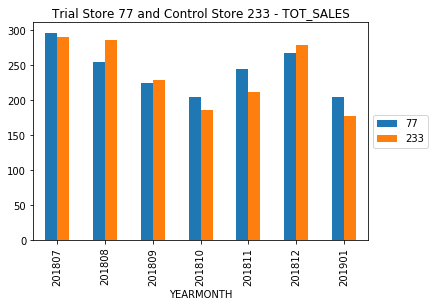

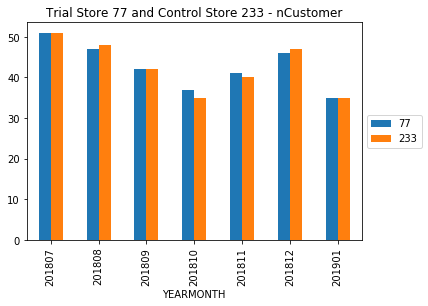

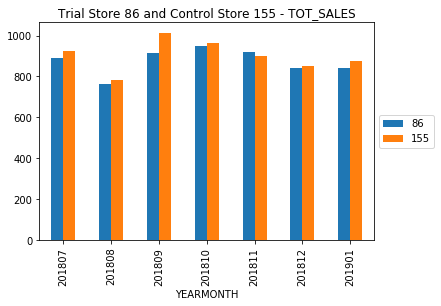

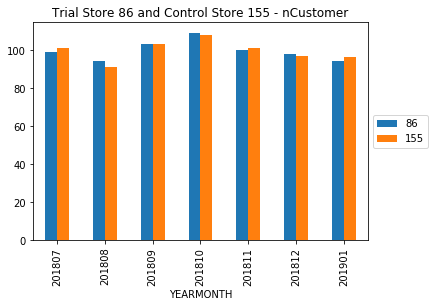

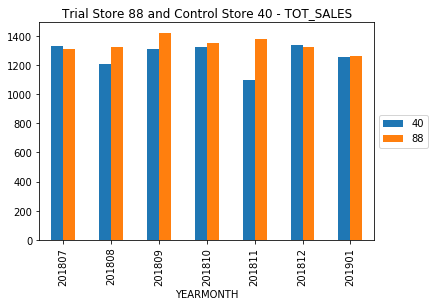

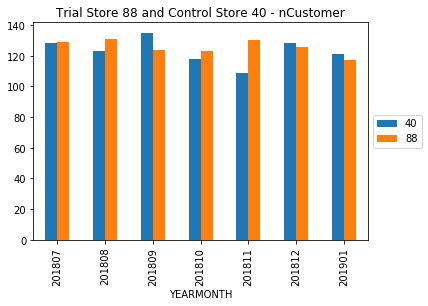

In [76]:
trial_control_dic = {77:233, 86:155, 88:40}
for key, val in trial_control_dic.items():
    pretrial_full_observ[pretrial_full_observ["STORE_NBR"].isin([key, val])].groupby(
        ["YEARMONTH", "STORE_NBR"]).sum()["TOT_SALES"].unstack().plot.bar()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store "+str(key)+" and Control Store "+str(val)+" - TOT_SALES")
    plt.show()
    pretrial_full_observ[pretrial_full_observ["STORE_NBR"].isin([key, val])].groupby(
    ["YEARMONTH", "STORE_NBR"]).sum()["nCustomers"].unstack().plot.bar()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store "+str(key)+" and Control Store "+str(val)+" - nCustomer")
    plt.show()
    print('\n')

Next we'll compare the performance of Trial stores to Control stores during the trial period. To ensure their performance is comparable during Trial period, we need to scale (multiply to ratio of trial / control) all of Control stores' performance to Trial store's performance during pre-trial. Starting with TOT_SALES.

In [77]:
#Ratio of Store 77 and its Control store.
sales_ratio_77 = pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 77]["TOT_SALES"].sum() / pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 233]["TOT_SALES"].sum()

#Ratio of Store 86 and its Control store.
sales_ratio_86 = pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 86]["TOT_SALES"].sum() / pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 155]["TOT_SALES"].sum()

#Ratio of Store 77 and its Control store.
sales_ratio_88 = pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 88]["TOT_SALES"].sum() / pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 40]["TOT_SALES"].sum()


In [78]:
trial_full_observ = full_observ[(full_observ["YEARMONTH"] >= 201902) & (full_observ["YEARMONTH"] <= 201904)]
scaled_sales_control_stores = full_observ[full_observ["STORE_NBR"].isin([233, 155, 40])][["STORE_NBR", "YEARMONTH", "TOT_SALES"]]

def scaler(row):
    if row["STORE_NBR"] == 233:
        return row["TOT_SALES"] * sales_ratio_77
    elif row["STORE_NBR"] == 155:
        return row["TOT_SALES"] * sales_ratio_86
    elif row["STORE_NBR"] == 40:
        return row["TOT_SALES"] * sales_ratio_88

scaled_sales_control_stores["ScaledSales"] = scaled_sales_control_stores.apply(lambda row: scaler(row), axis=1)

trial_scaled_sales_control_stores = scaled_sales_control_stores[(scaled_sales_control_stores["YEARMONTH"] >= 201902) & (scaled_sales_control_stores["YEARMONTH"] <= 201904)]
pretrial_scaled_sales_control_stores = scaled_sales_control_stores[scaled_sales_control_stores["YEARMONTH"] < 201902]

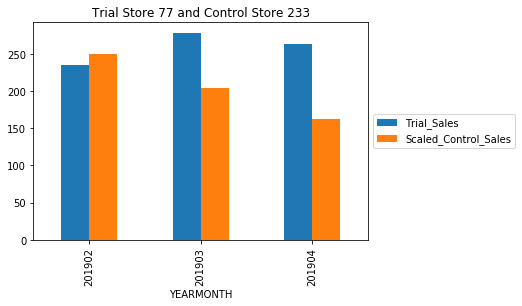

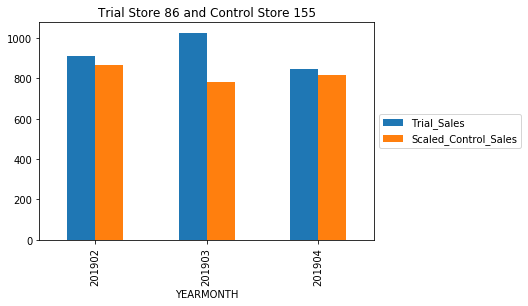

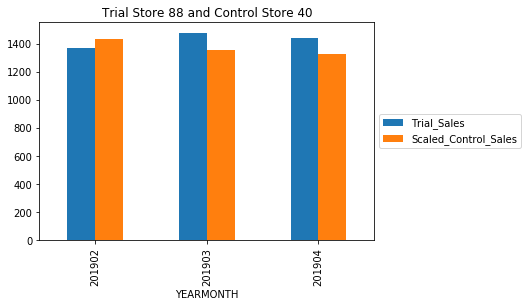

In [79]:
percentage_diff = {}

for trial, control in trial_control_dic.items():
    a = trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == control]
    b = trial_full_observ[trial_full_observ["STORE_NBR"] == trial][["STORE_NBR", "YEARMONTH", "TOT_SALES"]]
    percentage_diff[trial] = b["TOT_SALES"].sum() / a["ScaledSales"].sum()
    b[["YEARMONTH", "TOT_SALES"]].merge(a[["YEARMONTH", "ScaledSales"]],on="YEARMONTH").set_index("YEARMONTH").rename(columns={"ScaledSales":"Scaled_Control_Sales", "TOT_SALES":"Trial_Sales"}).plot.bar()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store "+str(trial)+" and Control Store "+str(control))

In [80]:
percentage_diff

{77: 1.2615468650086274, 86: 1.13150143573637, 88: 1.0434583458542188}

In [81]:
#Creating a compiled percentage_difference table
temp1 = scaled_sales_control_stores.sort_values(by=["STORE_NBR", "YEARMONTH"], ascending=[False, True]).reset_index().drop(["TOT_SALES", "index"], axis=1)
temp2 = full_observ[full_observ["STORE_NBR"].isin([77,86,88])][["STORE_NBR", "YEARMONTH", "TOT_SALES"]].reset_index().drop(["index", "YEARMONTH"], axis=1)
scaledsales_vs_trial = pd.concat([temp1, temp2], axis=1)
scaledsales_vs_trial.columns = ["c_STORE_NBR", "YEARMONTH", "c_ScaledSales", "t_STORE_NBR", "t_TOT_SALES"]
scaledsales_vs_trial["Sales_Percentage_Diff"] = (scaledsales_vs_trial["t_TOT_SALES"] - scaledsales_vs_trial["c_ScaledSales"]) / (((scaledsales_vs_trial["t_TOT_SALES"] + scaledsales_vs_trial["c_ScaledSales"])/2))
def label_period(cell):
    if cell < 201902:
        return "pre"
    elif cell > 201904:
        return "post"
    else:
        return "trial"
scaledsales_vs_trial["trial_period"] = scaledsales_vs_trial["YEARMONTH"].apply(lambda cell: label_period(cell))
scaledsales_vs_trial[scaledsales_vs_trial["trial_period"] == "trial"]

,c_STORE_NBR,YEARMONTH,c_ScaledSales,t_STORE_NBR,t_TOT_SALES,Sales_Percentage_Diff,trial_period
7,233,201902,249.762622,77,235.0,-0.060907,trial
8,233,201903,203.802205,77,278.5,0.309755,trial
9,233,201904,162.345704,77,263.5,0.475075,trial
19,155,201902,864.522060,86,913.2,0.054764,trial
20,155,201903,780.320405,86,1026.8,0.272787,trial
21,155,201904,819.317024,86,848.2,0.034642,trial
31,40,201902,1434.399269,88,1370.2,-0.045781,trial
32,40,201903,1352.064709,88,1477.2,0.088458,trial
33,40,201904,1321.797762,88,1439.4,0.085182,trial


Check significance of Trial minus Control stores TOT_SALES Percentage Difference Pre-Trial vs Trial.
- Step 1: Check null hypothesis of 0 difference between control store's Pre-Trial and Trial period performance.

- Step 2: Proof control and trial stores are similar statistically
    - Check p-value of control store's Pre-Trial vs Trial store's Pre-Trial.
    - If <5%, it is significantly different. If >5%, it is not significantly different (similar).

- Step 3: After checking Null Hypothesis of first 2 step to be true, we can check Null Hypothesis of Percentage Difference between Trial and Control stores during pre-trial is the same as during trial.
    - Check T-Value of Percentage Difference of each Trial month (Feb, March, April 2019).
    - Mean is mean of Percentage Difference during pre-trial.
    - Standard deviation is stdev of Percentage Difference during pre-trial.
    - Formula is Trial month's Percentage Difference minus Mean, divided by Standard deviation.
    - Compare each T-Value with 95% percentage significance critical t-value of 6 degrees of freedom (7 months of sample - 1)

In [82]:
from scipy.stats import ttest_ind, t

# Step 1
for num in [40, 155, 233]:
    print("Store", num)
    print(ttest_ind(pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores["STORE_NBR"] == num]["ScaledSales"],
                   trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == num]["ScaledSales"],
                   equal_var=False), '\n')
    #print(len(pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores["STORE_NBR"] == num]["ScaledSales"]), len(trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == num]["ScaledSales"]))
    
alpha = 0.05
print("Critical t-value for 95% confidence interval:")
print(t.ppf((alpha/2, 1-alpha/2), df=min([len(pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores["STORE_NBR"] == num]),
                       len(trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == num])])-1))

Store 40
Ttest_indResult(statistic=-0.5958372343168585, pvalue=0.5722861621434009) 

Store 155
Ttest_indResult(statistic=1.429195687929098, pvalue=0.19727058651603258) 

Store 233
Ttest_indResult(statistic=1.1911026010974504, pvalue=0.29445006064862156) 

Critical t-value for 95% confidence interval:
[-4.30265273  4.30265273]


In [83]:
a = pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores["STORE_NBR"] == 40]["ScaledSales"]
b = trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == 40]["ScaledSales"]

Null hypothesis is true. There isn't any statistically significant difference between control store's scaled Pre-Trial and Trial period sales.

In [84]:
# Step 2
for trial, cont in trial_control_dic.items():
    print("Trial store:", trial, ", Control store:", cont)
    print(ttest_ind(pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == trial]["TOT_SALES"],
                   pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores["STORE_NBR"] == cont]["ScaledSales"],
                   equal_var=True), '\n')
    #print(len(pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == trial]["TOT_SALES"]),len(pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores["STORE_NBR"] == cont]["ScaledSales"]))

alpha = 0.05
print("Critical t-value for 95% confidence interval:")
print(t.ppf((alpha/2, 1-alpha/2), df=len(pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == trial])-1))

Trial store: 77 , Control store: 233
Ttest_indResult(statistic=-1.2533353315065926e-15, pvalue=0.999999999999999) 

Trial store: 86 , Control store: 155
Ttest_indResult(statistic=0.0, pvalue=1.0) 

Trial store: 88 , Control store: 40
Ttest_indResult(statistic=0.0, pvalue=1.0) 

Critical t-value for 95% confidence interval:
[-2.44691185  2.44691185]


Null hypothesis is true. There isn't any statistically significant difference between Trial store's sales and Control store's scaled-sales performance during pre-trial.

In [85]:
# Step 3
for trial, cont in trial_control_dic.items():
    print("Trial store:", trial, ", Control store:", cont)
    temp_pre = scaledsales_vs_trial[(scaledsales_vs_trial["c_STORE_NBR"] == cont) & (scaledsales_vs_trial["trial_period"]=="pre")]
    std = temp_pre["Sales_Percentage_Diff"].std()
    mean = temp_pre["Sales_Percentage_Diff"].mean()
    #print(std, mean)
    for t_month in scaledsales_vs_trial[scaledsales_vs_trial["trial_period"] == "trial"]["YEARMONTH"].unique():
        pdif = scaledsales_vs_trial[(scaledsales_vs_trial["YEARMONTH"] == t_month) & (scaledsales_vs_trial["t_STORE_NBR"] == trial)]["Sales_Percentage_Diff"]
        print(t_month,":",(float(pdif)-mean)/std)
    print('\n')
    
print("Critical t-value for 95% confidence interval:")
conf_intv_95 = t.ppf(0.95, df=len(temp_pre)-1)
print(conf_intv_95)

Trial store: 77 , Control store: 233
201902 : -0.7171038288055888
201903 : 3.035317928855662
201904 : 4.708944418758203


Trial store: 86 , Control store: 155
201902 : 1.4133618775921797
201903 : 7.123063846042149
201904 : 0.8863824572944162


Trial store: 88 , Control store: 40
201902 : -0.5481633746817604
201903 : 1.0089992743637755
201904 : 0.9710006270463645


Critical t-value for 95% confidence interval:
1.9431802803927816


There are 3 months' increase in performance that are statistically significant (Above the 95% confidence interval t-score):
- March and April trial months for trial store 77
- March trial months for trial store 86

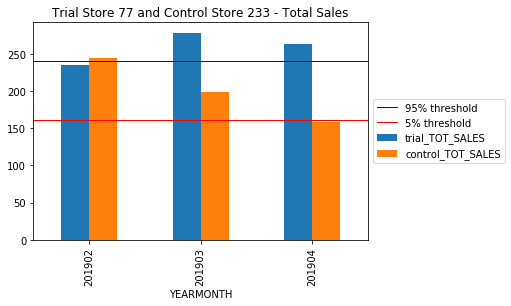

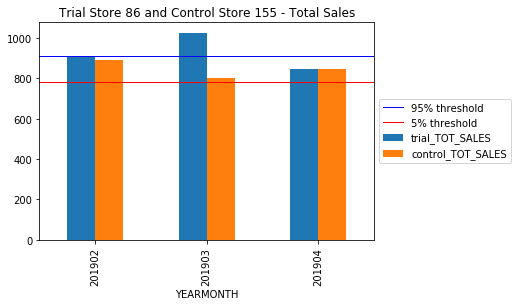

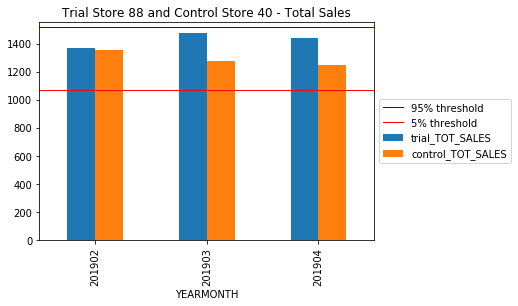

In [129]:
for trial, control in trial_control_dic.items():
    a = trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == control].rename(columns={"TOT_SALES": "control_TOT_SALES"})
    b = trial_full_observ[trial_full_observ["STORE_NBR"] == trial][["STORE_NBR", "YEARMONTH", "TOT_SALES"]].rename(columns={"TOT_SALES": "trial_TOT_SALES"})
    comb = b[["YEARMONTH", "trial_TOT_SALES"]].merge(a[["YEARMONTH", "control_TOT_SALES"]],on="YEARMONTH").set_index("YEARMONTH")
    comb.plot.bar()
    cont_sc_sales = trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == control]["TOT_SALES"]
    std = scaledsales_vs_trial[(scaledsales_vs_trial["c_STORE_NBR"] == control) & (scaledsales_vs_trial["trial_period"]=="pre")]["Sales_Percentage_Diff"].std()
    thresh95 = cont_sc_sales.mean() + (cont_sc_sales.mean() * std * 2)
    thresh5 = cont_sc_sales.mean() - (cont_sc_sales.mean() * std * 2)
    plt.axhline(y=thresh95,linewidth=1, color='b', label="95% threshold")
    plt.axhline(y=thresh5,linewidth=1, color='r', label="5% threshold")
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store "+str(trial)+" and Control Store "+str(control)+" - Total Sales")
    plt.savefig("TS {} and CS {} - TOT_SALES.png".format(trial,control), bbox_inches="tight")

We can see that Trial store 77 sales for March and April exceeds 95% threshold of control store. Same goes to store 86 sales for March.

Next, we'll look into nCustomers.

In [87]:
#Ratio of Store 77 and its Control store.
ncust_ratio_77 = pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 77]["nCustomers"].sum() / pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 233]["nCustomers"].sum()

#Ratio of Store 86 and its Control store.
ncust_ratio_86 = pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 86]["nCustomers"].sum() / pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 155]["nCustomers"].sum()

#Ratio of Store 77 and its Control store.
ncust_ratio_88 = pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 88]["nCustomers"].sum() / pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 40]["nCustomers"].sum()


In [88]:
#trial_full_observ = full_observ[(full_observ["YEARMONTH"] >= 201902) & (full_observ["YEARMONTH"] <= 201904)]
scaled_ncust_control_stores = full_observ[full_observ["STORE_NBR"].isin([233, 155, 40])][["STORE_NBR", "YEARMONTH", "nCustomers"]]

def scaler_c(row):
    if row["STORE_NBR"] == 233:
        return row["nCustomers"] * ncust_ratio_77
    elif row["STORE_NBR"] == 155:
        return row["nCustomers"] * ncust_ratio_86
    elif row["STORE_NBR"] == 40:
        return row["nCustomers"] * ncust_ratio_88

scaled_ncust_control_stores["ScaledNcust"] = scaled_ncust_control_stores.apply(lambda row: scaler_c(row), axis=1)

trial_scaled_ncust_control_stores = scaled_ncust_control_stores[(scaled_ncust_control_stores["YEARMONTH"] >= 201902) & (scaled_ncust_control_stores["YEARMONTH"] <= 201904)]
pretrial_scaled_ncust_control_stores = scaled_ncust_control_stores[scaled_ncust_control_stores["YEARMONTH"] < 201902]

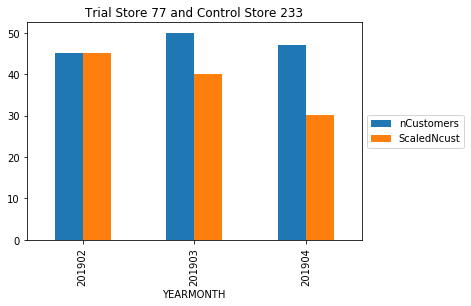

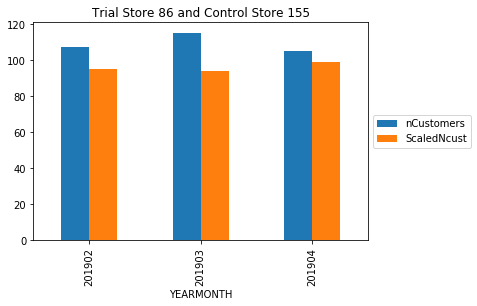

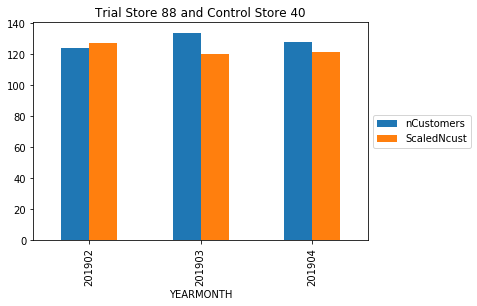

In [89]:
ncust_percentage_diff = {}

for trial, control in trial_control_dic.items():
    a = trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores["STORE_NBR"] == control]
    b = trial_full_observ[trial_full_observ["STORE_NBR"] == trial][["STORE_NBR", "YEARMONTH", "nCustomers"]]
    ncust_percentage_diff[trial] = b["nCustomers"].sum() / a["ScaledNcust"].sum()
    b[["YEARMONTH", "nCustomers"]].merge(a[["YEARMONTH", "ScaledNcust"]],on="YEARMONTH").set_index("YEARMONTH").rename(columns={"ScaledSales":"Scaled_Control_nCust", "TOT_SALES":"Trial_nCust"}).plot.bar()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store "+str(trial)+" and Control Store "+str(control))

In [90]:
ncust_percentage_diff

{77: 1.2306529009742622, 86: 1.1354166666666667, 88: 1.0444876946258161}

In [91]:
#Creating a compiled ncust_percentage_difference table
temp1 = scaled_ncust_control_stores.sort_values(by=["STORE_NBR", "YEARMONTH"], ascending=[False, True]).reset_index().drop(["nCustomers", "index"], axis=1)
temp2 = full_observ[full_observ["STORE_NBR"].isin([77,86,88])][["STORE_NBR", "YEARMONTH", "nCustomers"]].reset_index().drop(["index", "YEARMONTH"], axis=1)
scaledncust_vs_trial = pd.concat([temp1, temp2], axis=1)
scaledncust_vs_trial.columns = ["c_STORE_NBR", "YEARMONTH", "c_ScaledNcust", "t_STORE_NBR", "t_nCustomers"]
scaledncust_vs_trial["nCust_Percentage_Diff"] = (scaledncust_vs_trial["t_nCustomers"] - scaledncust_vs_trial["c_ScaledNcust"]) / (((scaledncust_vs_trial["t_nCustomers"] + scaledncust_vs_trial["c_ScaledNcust"])/2))

scaledncust_vs_trial["trial_period"] = scaledncust_vs_trial["YEARMONTH"].apply(lambda cell: label_period(cell))
scaledncust_vs_trial[scaledncust_vs_trial["trial_period"] == "trial"]

,c_STORE_NBR,YEARMONTH,c_ScaledNcust,t_STORE_NBR,t_nCustomers,nCust_Percentage_Diff,trial_period
7,233,201902,45.151007,77,45,-0.003350,trial
8,233,201903,40.134228,77,50,0.218913,trial
9,233,201904,30.100671,77,47,0.438370,trial
19,155,201902,95.000000,86,107,0.118812,trial
20,155,201903,94.000000,86,115,0.200957,trial
21,155,201904,99.000000,86,105,0.058824,trial
31,40,201902,127.610209,88,124,-0.028697,trial
32,40,201903,120.464037,88,134,0.106388,trial
33,40,201904,121.484919,88,128,0.052228,trial


Check significance of Trial minus Control stores nCustomers Percentage Difference Pre-Trial vs Trial.
- Step 1: Check null hypothesis of 0 difference between control store's Pre-Trial and Trial period performance.
- Step 2: Proof control and trial stores are similar statistically
- Step 3: After checking Null Hypothesis of first 2 step to be true, we can check Null Hypothesis of Percentage Difference between Trial and Control stores during pre-trial is the same as during trial.

In [92]:
# Step 1
for num in [40, 155, 233]:
    print("Store", num)
    print(ttest_ind(pretrial_scaled_ncust_control_stores[pretrial_scaled_ncust_control_stores["STORE_NBR"] == num]["ScaledNcust"],
                   trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores["STORE_NBR"] == num]["ScaledNcust"],
                   equal_var=False), '\n')
    
alpha = 0.05
print("Critical t-value for 95% confidence interval:")
print(t.ppf((alpha/2, 1-alpha/2), df=min([len(pretrial_scaled_ncust_control_stores[pretrial_scaled_ncust_control_stores["STORE_NBR"] == num]),
                       len(trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores["STORE_NBR"] == num])])-1))

Store 40
Ttest_indResult(statistic=0.644732693420032, pvalue=0.5376573016017127) 

Store 155
Ttest_indResult(statistic=1.3888888888888882, pvalue=0.204345986327886) 

Store 233
Ttest_indResult(statistic=0.8442563765225701, pvalue=0.4559280037660254) 

Critical t-value for 95% confidence interval:
[-4.30265273  4.30265273]


In [93]:
# Step 2
for trial, cont in trial_control_dic.items():
    print("Trial store:", trial, ", Control store:", cont)
    print(ttest_ind(pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == trial]["nCustomers"],
                   pretrial_scaled_ncust_control_stores[pretrial_scaled_ncust_control_stores["STORE_NBR"] == cont]["ScaledNcust"],
                   equal_var=True), '\n')

alpha = 0.05
print("Critical t-value for 95% confidence interval:")
print(t.ppf((alpha/2, 1-alpha/2), df=len(pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == trial])-1))

Trial store: 77 , Control store: 233
Ttest_indResult(statistic=0.0, pvalue=1.0) 

Trial store: 86 , Control store: 155
Ttest_indResult(statistic=0.0, pvalue=1.0) 

Trial store: 88 , Control store: 40
Ttest_indResult(statistic=-7.648483953264653e-15, pvalue=0.999999999999994) 

Critical t-value for 95% confidence interval:
[-2.44691185  2.44691185]


In [94]:
# Step 3
for trial, cont in trial_control_dic.items():
    print("Trial store:", trial, ", Control store:", cont)
    temp_pre = scaledncust_vs_trial[(scaledncust_vs_trial["c_STORE_NBR"] == cont) & (scaledncust_vs_trial["trial_period"]=="pre")]
    std = temp_pre["nCust_Percentage_Diff"].std()
    mean = temp_pre["nCust_Percentage_Diff"].mean()
    #print(std, mean)
    for t_month in scaledncust_vs_trial[scaledncust_vs_trial["trial_period"] == "trial"]["YEARMONTH"].unique():
        pdif = scaledncust_vs_trial[(scaledncust_vs_trial["YEARMONTH"] == t_month) & (scaledncust_vs_trial["t_STORE_NBR"] == trial)]["nCust_Percentage_Diff"]
        print(t_month,":",(float(pdif)-mean)/std)
    print('\n')
    
print("Critical t-value for 95% confidence interval:")
conf_intv_95 = t.ppf(0.95, df=len(temp_pre)-1)
print(conf_intv_95)

Trial store: 77 , Control store: 233
201902 : -0.19886295797440687
201903 : 8.009609025380932
201904 : 16.114474772873923


Trial store: 86 , Control store: 155
201902 : 6.220524882227514
201903 : 10.52599074274189
201904 : 3.0763575852842706


Trial store: 88 , Control store: 40
201902 : -0.3592881735131531
201903 : 1.2575196020616801
201904 : 0.6092905590514273


Critical t-value for 95% confidence interval:
1.9431802803927816


There are 5 months' increase in performance that are statistically significant (Above the 95% confidence interval t-score):
- March and April trial months for trial store 77
- Feb, March and April trial months for trial store 86

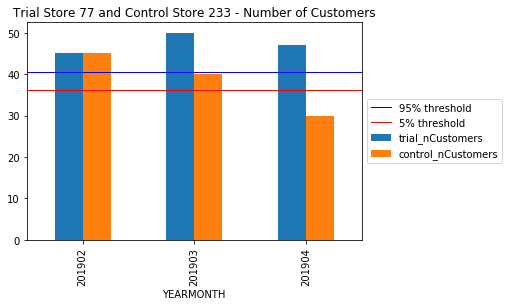

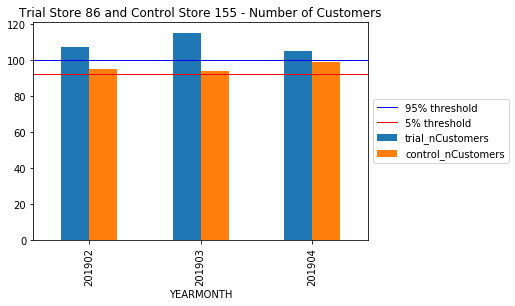

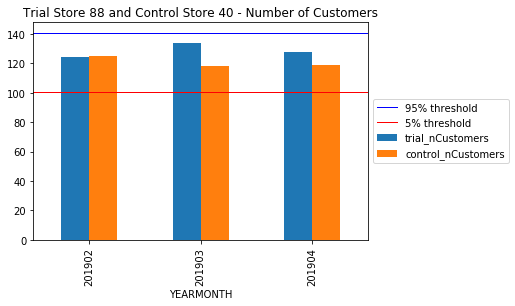

In [128]:
for trial, control in trial_control_dic.items():
    a = trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores["STORE_NBR"] == control].rename(columns={"nCustomers": "control_nCustomers"})
    b = trial_full_observ[trial_full_observ["STORE_NBR"] == trial][["STORE_NBR", "YEARMONTH", "nCustomers"]].rename(columns={"nCustomers": "trial_nCustomers"})
    comb = b[["YEARMONTH", "trial_nCustomers"]].merge(a[["YEARMONTH", "control_nCustomers"]],on="YEARMONTH").set_index("YEARMONTH")
    comb.plot.bar()
    cont_sc_ncust = trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores["STORE_NBR"] == control]["nCustomers"]
    std = scaledncust_vs_trial[(scaledncust_vs_trial["c_STORE_NBR"] == control) & (scaledncust_vs_trial["trial_period"]=="pre")]["nCust_Percentage_Diff"].std()
    thresh95 = cont_sc_ncust.mean() + (cont_sc_ncust.mean() * std * 2)
    thresh5 = cont_sc_ncust.mean() - (cont_sc_ncust.mean() * std * 2)
    plt.axhline(y=thresh95,linewidth=1, color='b', label="95% threshold")
    plt.axhline(y=thresh5,linewidth=1, color='r', label="5% threshold")
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store "+str(trial)+" and Control Store "+str(control)+" - Number of Customers")
    plt.savefig("TS {} and CS {} - nCustomers.png".format(trial,control), bbox_inches="tight")

We can see that Trial store 77 sales for Feb, March, and April exceeds 95% threshold of control store.
Same goes to store 86 sales for all 3 trial months.

- Trial store 77: Control store 233
- Trial store 86: Control store 155
- Trial store 88: Control store 40
- Both trial store 77 and 86 showed significant increase in Total Sales and Number of Customers during trial period. But not for trial store 88. Perhaps the client knows if there's anything about trial 88 that differs it from the other two trial.
- Overall the trial showed positive significant result.